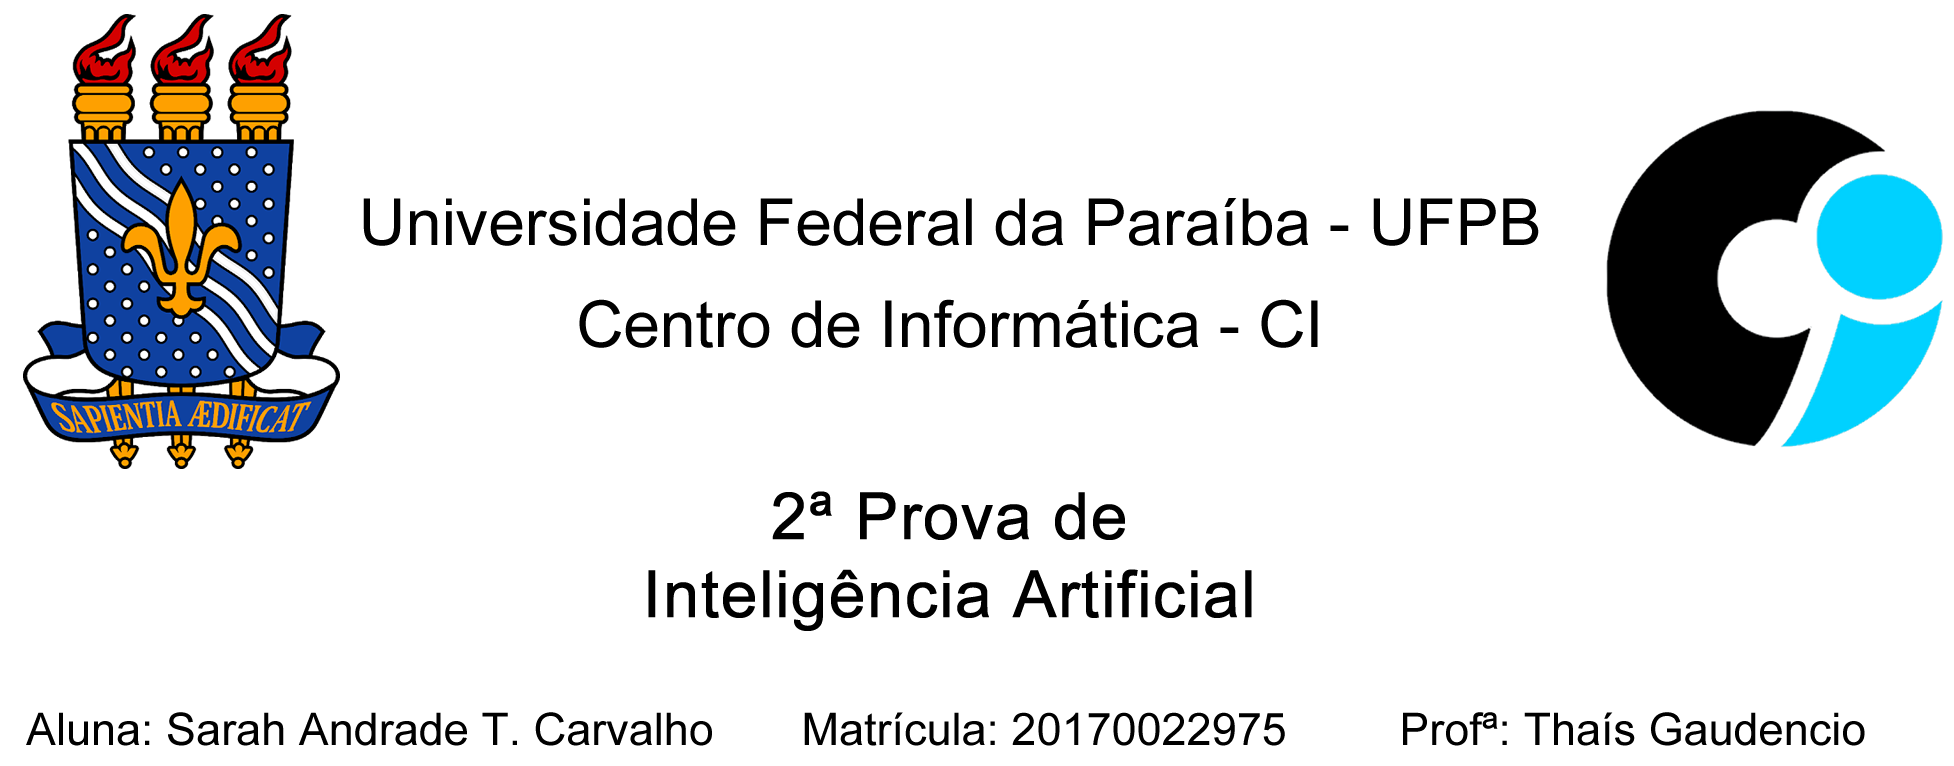

In [1]:
from IPython.display import Image
Image(filename='img/cabecalho.fw.png', width="700px")

# Questão 1

Acessar a base de dados HCV (https://archive.ics.uci.edu/ml/datasets/HCV+data#) e desenvolver **dois** algoritmos supervisionados, podendo ser Redes Neurais Artificiais, Árvore de Decisão ou outros de sua escolha, para classificação entre Doador ou Não Doador, que são positivos para Hepatite C, Fibrose ou Cirrose. 

Ambos modelos devem ser analisados pelas métricas: Acurácia, Especificidade, Sensibilidade e Matriz de Confusão e os resultados devem ser discutidos. Na base consta instâncias rotuladas como Possíveis Doadores (0s=suspect Blood Donor), que devem ser classificadas separadamente após a construção dos modelos, compare os resultados obtidos em cada método utilizado.

### Importação das bibliotecas

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


In [3]:
from numpy.random import seed
import tensorflow
SEED=1624
#2190
tensorflow.random.set_seed(SEED)

### Importação da base de dados

In [4]:
dataset = pd.read_csv('./database/data-Q1.csv', delimiter=',', index_col=0)


#### Codificação da variável independete, atributo "Sex"

In [5]:
dataset['Sex'] = dataset['Sex'].replace({'m': 0, 'f': 1})

In [6]:
dataset.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
1,0=Blood Donor,32,0,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
2,0=Blood Donor,32,0,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
3,0=Blood Donor,32,0,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
4,0=Blood Donor,32,0,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
5,0=Blood Donor,32,0,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


#### Análise de correlação

In [7]:
corr = dataset.corr()
corr.style.background_gradient(cmap='cool')
# Nenhum caso relevante de alta correlação

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
Age,1.000000,0.024544,-0.197498,0.173340,-0.006021,0.088666,0.032492,-0.075093,0.125641,-0.022296,0.153087,-0.153668
Sex,0.024544,1.000000,-0.146140,0.019825,-0.161868,-0.130891,-0.111177,-0.169111,0.030208,-0.159589,-0.133276,-0.051277
ALB,-0.197498,-0.146140,1.000000,-0.141584,0.001606,-0.193450,-0.221651,0.375878,0.208248,-0.001573,-0.155749,0.557197
ALP,0.173340,0.019825,-0.141584,1.000000,0.214480,0.063948,0.056078,0.033753,0.125429,0.149832,0.454630,-0.055109
ALT,-0.006021,-0.161868,0.001606,0.214480,1.000000,0.273326,-0.038469,0.147000,0.068947,-0.043025,0.248114,0.094730
AST,0.088666,-0.130891,-0.193450,0.063948,0.273326,1.000000,0.312231,-0.208536,-0.209970,-0.021387,0.491263,0.040071
BIL,0.032492,-0.111177,-0.221651,0.056078,-0.038469,0.312231,1.000000,-0.333172,-0.180370,0.031224,0.217024,-0.047638
CHE,-0.075093,-0.169111,0.375878,0.033753,0.147000,-0.208536,-0.333172,1.000000,0.425456,-0.011157,-0.110345,0.295427
CHOL,0.125641,0.030208,0.208248,0.125429,0.068947,-0.209970,-0.180370,0.425456,1.000000,-0.047744,-0.006895,0.207071
CREA,-0.022296,-0.159589,-0.001573,0.149832,-0.043025,-0.021387,0.031224,-0.011157,-0.047744,1.000000,0.121003,-0.031704


In [8]:
dataset["Category"].value_counts().sort_index()

0=Blood Donor             533
0s=suspect Blood Donor      7
1=Hepatitis                24
2=Fibrosis                 21
3=Cirrhosis                30
Name: Category, dtype: int64

## Pré-processamento

### Verificação de dados nulos

In [9]:
dataset.isnull().sum()

Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64

### Exclusão dos dados nulos

In [10]:
dataset=dataset.dropna()

In [11]:
dataset.isnull().sum()

Category    0
Age         0
Sex         0
ALB         0
ALP         0
ALT         0
AST         0
BIL         0
CHE         0
CHOL        0
CREA        0
GGT         0
PROT        0
dtype: int64

### Dados duplicados

In [12]:
dataset.duplicated().sum()

0

### Análise de boxplot e tratamento de outlier

Text(0.5, 1.0, 'Base de dados original - outliers')

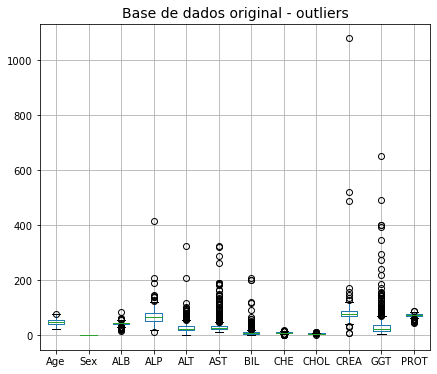

In [13]:
dataset.boxplot(grid=True, figsize= (7,6))
plt.title('Base de dados original - outliers', fontsize=14)

In [14]:
dataset_orig = dataset

In [15]:

from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
!pip install sklearn_pandas
from sklearn_pandas import DataFrameMapper

column_tuples = [
    ('Category', None),
    ('Age', None),
    (['Sex'], None),
    (['ALB'], RobustScaler()),
    (['ALP'], RobustScaler()),
    (['ALT'], RobustScaler()),
    (['AST'], RobustScaler()),
    (['BIL'], RobustScaler()),
    (['CHE'], RobustScaler()),
    (['CHOL'], RobustScaler()),
    (['CREA'], RobustScaler()),
    (['GGT'], RobustScaler()),
    (['PROT'], RobustScaler())
]

mapper = DataFrameMapper(column_tuples, df_out=True)
dataset = mapper.fit_transform(dataset)

dataset.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
1,0=Blood Donor,32,0,-0.539683,-0.500000,-0.967742,-0.352941,0.068966,-0.503788,-1.424658,1.380952,-0.486364,-0.525424
2,0=Blood Donor,32,0,-0.539683,0.149635,-0.303226,-0.098039,-0.551724,1.102273,-0.349315,-0.142857,-0.327273,0.745763
3,0=Blood Donor,32,0,0.793651,0.310219,0.870968,2.637255,-0.172414,0.219697,-0.075342,0.428571,0.472727,1.220339
4,0=Blood Donor,32,0,0.206349,-0.518248,0.509677,-0.303922,2.034483,-0.352273,-0.390411,0.142857,0.500000,0.610169
5,0=Blood Donor,32,0,-0.428571,0.288321,0.638710,-0.088235,0.431034,0.337121,-0.678082,-0.047619,0.322727,-0.576271


Text(0.5, 1.0, 'Base de dados normalizada')

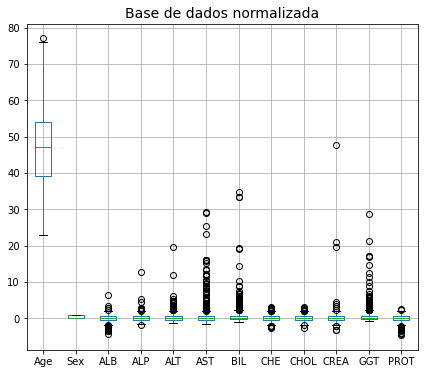

In [16]:
dataset.boxplot(grid=True, figsize= (7,6))
plt.title('Base de dados normalizada', fontsize=14)

Text(0.5, 1.0, 'Base de dados não normalizada')

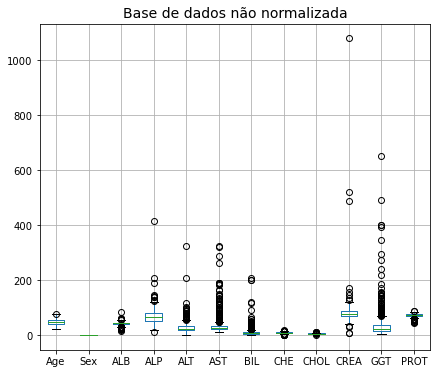

In [17]:
dataset_orig.boxplot(grid=True, figsize= (7,6))
plt.title('Base de dados não normalizada', fontsize=14)

### Divisão do dataset em dados de entrada (x) e de saída (y)

In [18]:
x = dataset.iloc[:, 1:].values
x_orig = dataset_orig.iloc[:, 1:].values

In [19]:
y = dataset.iloc[:, 0:1].values
y_orig= dataset_orig.iloc[:, 0:1].values


In [20]:
#dimensão dos dados
x.shape

(589, 12)

### Codificação da Variável Dependente
→ Inicialmente todos os 4 rótulos do atributo _category_ serão codificados de string para números inteiros de 0-4, onde:
- 0: Blood Donor
- 1: Suspect Blood Donor
- 2: Hepatitis
- 3: Fibrosis
- 4: Cirrhosis


In [21]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
y_orig = le.fit_transform(y_orig)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [22]:
print(y)
print(y_orig)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

→ E em seguida, é realizada uma nova análise desses novos valores com o intuito de identificar quais deles são referentes ao casos: 
- Suspect Blood Donor (-1)
- Blood Donor (0)
- No Blood Donor (1)

Nesta etapa também é realizada a indexação das posições referentes as amostras dos casos suspeitos

In [23]:
i=0
suspect_index=[]
for i in range(0,len(y)):
    if(y[i]==1):
        y[i]=-1
        y_orig[i]=-1
        suspect_index.append(i)
    if(y[i]>=2):
        y[i]=1
        y_orig[i]=1

### Divisão do dataset entre casos supeitos e casos confiáveis
Com a utilização do array dos index das amostras suspeitas é realizada uma cópia dos atributos dessas amostras, as quais são armazenadas em x_suspect. E, de modo subsequente, todas os dados dos casos suspeitos são apagados do dataset x e y. 

In [24]:
print(suspect_index)

[526, 527, 528, 529, 530, 531, 532]


In [25]:
#Cópia dos dados x das amostras suspeitas para um novo array 
x_suspect=[0]*len(suspect_index)
x_suspect_orig =[0]*len(suspect_index)

for i in range (0, len(suspect_index)):
    x_suspect[i]=x[suspect_index[i]] #Salva os valores dos casos suspeitos em um array separado
    x_suspect_orig[i]=x_orig[suspect_index[i]]
    
x_suspect=np.array(x_suspect)#Converte a lista para numpy
x_suspect_orig=np.array(x_suspect_orig)


In [26]:
#Retirada dos valores suspeitos do y
y = np.delete(y, suspect_index, axis=0)
y_orig = np.delete(y_orig, suspect_index, axis=0)
print("Y dos doadores e não doadores:\n", y)


Y dos doadores e não doadores:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [27]:
# exclusão dos casos suspeitos do dataset confiável
x = np.delete(x, suspect_index, axis=0)
x_orig = np.delete(x_orig, suspect_index, axis=0)


### Balanceamento dos dados

In [28]:
### Undersampling
!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='auto', random_state=SEED)
x, y = undersample.fit_resample(x, y)

x_orig, y_orig = undersample.fit_resample(x_orig, y_orig)

In [29]:
print(len(x))
print(len(y))

print(len(x_orig))
print(len(y_orig))

112
112
112
112


### Dividindo a base confiável em amostras de treinamento e teste

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(x_orig, y_orig, test_size = 0.2, random_state = 0)


### Feature Scaling

In [31]:
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)
#x_suspect = sc.transform(x_suspect)

## Algoritmo 1: Rede Neural Artificial, Perceptron com camada de entrada e saída

### Construção da Rede Neural

In [32]:
ann = tf.keras.models.Sequential()
ann_orig = tf.keras.models.Sequential()

### Adicionando neurônios e camadas

In [33]:
#Camada de entrada
ann.add(tf.keras.layers.Dense(units=12, activation='relu')) #Modelo normalizado
ann_orig.add(tf.keras.layers.Dense(units=12, activation='relu'))#Modelo n-normalizado

In [34]:
#Camada oculta
ann.add(tf.keras.layers.Dense(units=3, activation='relu'))#Modelo normalizado
ann_orig.add(tf.keras.layers.Dense(units=3, activation='relu'))#Modelo n-normalizado

In [35]:
#Camada de saída
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))#Modelo normalizado
ann_orig.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))#Modelo n-normalizado

### Treinando a Rede

In [36]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])#Modelo normalizado
ann_orig.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])#Modelo n-normalizado

In [37]:
history = ann.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=10, verbose=0)
history_orig = ann.fit(X_train_orig, y_train_orig, validation_split=0.2, epochs=200, batch_size=10, verbose=0)

### Predição dos resultados e análise do modelo

In [38]:
#Normalizado
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred= np.multiply(y_pred, 1)

In [39]:
#N-Normalizado
y_pred_orig = ann.predict(X_test_orig)
y_pred_orig = (y_pred_orig > 0.5)
y_pred_orig= np.multiply(y_pred_orig, 1)

#### Matriz de Confusão

In [40]:
#Normalizado
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[11  0]
 [ 1 11]]


In [41]:
#N-Normalizado
from sklearn.metrics import confusion_matrix, accuracy_score
cm_orig = confusion_matrix(y_test_orig, y_pred_orig)
print(cm_orig)

[[10  1]
 [ 1 11]]


#### Sensibilidade

In [42]:
#Normalizado
print (cm[1][1] / (cm[0][1]+cm[1][1]))

1.0


In [43]:
#N-Normalizado
print (cm_orig[1][1] / (cm_orig[0][1]+cm_orig[1][1]))

0.9166666666666666


#### Especificidade

In [44]:
#Normalizado
print (cm[0][0] / (cm[0][0]+cm[1][0]))

0.9166666666666666


In [45]:
#N-Normalizado
print (cm_orig[0][0] / (cm_orig[0][0]+cm_orig[1][0]))

0.9090909090909091


#### Acurácia

In [46]:
#Normalizada
acc= accuracy_score(y_test, y_pred)
acc

0.9565217391304348

In [47]:
#N-normalizada
acc_orig=accuracy_score(y_test_orig, y_pred_orig)
acc_orig

0.9130434782608695

In [48]:
from sklearn import metrics
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.92      0.96        12

    accuracy                           0.96        23
   macro avg       0.96      0.96      0.96        23
weighted avg       0.96      0.96      0.96        23



### Análise Gráfica do loss do modelo

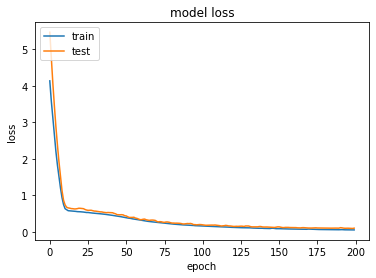

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

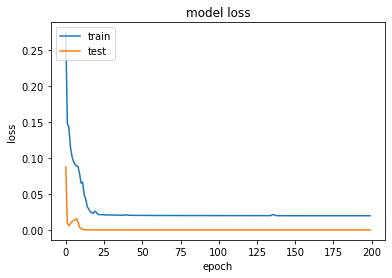

In [50]:
plt.plot(history_orig.history['loss'])
plt.plot(history_orig.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Classificação dos casos suspeitos

In [51]:
y_pred_suspect = ann.predict(np.array(x_suspect))
y_pred_suspect = (y_pred_suspect>0.5)
y_pred_suspect= np.multiply(y_pred_suspect, 1)


In [52]:
y_pred_suspect_orig = ann_orig.predict(np.array(x_suspect_orig))
y_pred_suspect_orig = (y_pred_suspect_orig>0.5)
y_pred_suspect_orig= np.multiply(y_pred_suspect_orig, 1)
print(y_pred_suspect.T)
print(y_pred_suspect_orig.T)

[[0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]]


## Algoritmo 2: Árvore de decisão

In [53]:
from sklearn.tree import DecisionTreeClassifier

In [54]:
clf = DecisionTreeClassifier(random_state = SEED)
clf_orig = DecisionTreeClassifier(random_state = SEED)

### Treinamento da árvore

In [55]:
clf = clf.fit(X_train,y_train)
clf_orig = clf_orig.fit(X_train_orig, y_train)

### Predição do resultado

In [56]:
arvore_prediction = clf.predict(X_test)

arvore_prediction_orig = clf_orig.predict(X_test_orig)

### Análise do resultado

#### Acurácia

In [57]:
#Normalizada
accuracy_score(y_test, arvore_prediction)
print(metrics.classification_report(y_test,arvore_prediction))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       1.00      0.83      0.91        12

    accuracy                           0.91        23
   macro avg       0.92      0.92      0.91        23
weighted avg       0.93      0.91      0.91        23



In [58]:
#N-normalizada
accuracy_score(y_test_orig, arvore_prediction_orig)
print(metrics.classification_report(y_test,arvore_prediction_orig))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       1.00      0.83      0.91        12

    accuracy                           0.91        23
   macro avg       0.92      0.92      0.91        23
weighted avg       0.93      0.91      0.91        23



#### Matriz de confusão

In [59]:
cm = confusion_matrix(y_test, arvore_prediction)
cm

array([[11,  0],
       [ 2, 10]], dtype=int64)

In [60]:
cm_orig = confusion_matrix(y_test_orig, arvore_prediction_orig)
cm_orig

array([[11,  0],
       [ 2, 10]], dtype=int64)

#### Sensibilidade

In [61]:
print (cm[1][1] / (cm[0][1]+cm[1][1]))

1.0


In [62]:
print (cm_orig[1][1] / (cm_orig[0][1]+cm_orig[1][1]))

1.0



#### Especificidade


In [63]:
print (cm[0][0] / (cm[0][0]+cm[1][0]))

0.8461538461538461


In [64]:
print (cm_orig[0][0] / (cm_orig[0][0]+cm_orig[1][0]))

0.8461538461538461


### Classificação dos casos suspeitos com árvore

In [65]:
arvore_pred_suspect = clf.predict(x_suspect)
arvore_pred_suspect = (arvore_pred_suspect>0.5)
arvore_pred_suspect = np.multiply(arvore_pred_suspect, 1)

In [66]:
arvore_pred_suspect_orig = clf_orig.predict(x_suspect_orig)
arvore_pred_suspect_orig = (arvore_pred_suspect_orig>0.5)
arvore_pred_suspect_orig = np.multiply(arvore_pred_suspect_orig, 1)

## Comparação entre resultados da ann e da árvore de decisão

In [67]:
print(y_pred_suspect.T)
print(y_pred_suspect_orig.T)

print(arvore_pred_suspect)
print(arvore_pred_suspect_orig)
print("\nLegenda:\n 0 = Doador de sangue,  1 = Não doador de sangue")

[[0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]]
[0 0 0 0 1 0 0]
[0 0 0 0 1 0 0]

Legenda:
 0 = Doador de sangue,  1 = Não doador de sangue


# Questão 2

Utilizando a base de dados Wine DataSet (https://archive.ics.uci.edu/ml/datasets/wine), utilize **dois** algoritmos não supervisionados, podendo ser K-means, Hierárquico ou outros de sua escolha. 

Ambos os modelos devem ser analisados através da métrica silhueta ou outra métrica de sua escolha. Os resultados devem ser discutidos.

## Importação da base de dados

In [863]:
df = pd.read_csv('./database/data-Q2.csv', delimiter=',', index_col=0)

In [864]:
df.head()

,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted_wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Pré-processamento

### Dados faltantes

In [865]:
df.isnull().sum()

Alcohol                         0
Malic_acid                      0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
OD280/OD315_of_diluted_wines    0
Proline                         0
dtype: int64

### Dados duplicados

In [866]:
df.duplicated().sum()

0

### Correlação

In [867]:
import pandas as pd
import numpy as np

corr = df.corr()
corr.style.background_gradient(cmap='cool')

,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted_wines,Proline
Alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720
Malic_acid,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011
Ash,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626
Alcalinity_of_ash,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597
Magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351
Total_phenols,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115
Flavanoids,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193
Nonflavanoid_phenols,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385
Proanthocyanins,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417
Color_intensity,0.546364,0.248985,0.258887,0.018732,0.199950,-0.055136,-0.172379,0.139057,-0.025250,1.000000,-0.521813,-0.428815,0.316100


In [868]:
df = df.drop(columns=['Total_phenols','Alcalinity_of_ash','Proanthocyanins','Malic_acid','Ash','Magnesium','Color_intensity']) #alta correlação com Flavanoids
df.head()

,Alcohol,Flavanoids,Nonflavanoid_phenols,Hue,OD280/OD315_of_diluted_wines,Proline
0,14.23,3.06,0.28,1.04,3.92,1065
1,13.20,2.76,0.26,1.05,3.40,1050
2,13.16,3.24,0.30,1.03,3.17,1185
3,14.37,3.49,0.24,0.86,3.45,1480
4,13.24,2.69,0.39,1.04,2.93,735


In [869]:
corr = df.corr()
corr.style.background_gradient(cmap='cool')

,Alcohol,Flavanoids,Nonflavanoid_phenols,Hue,OD280/OD315_of_diluted_wines,Proline
Alcohol,1.000000,0.236815,-0.155929,-0.071747,0.072343,0.643720
Flavanoids,0.236815,1.000000,-0.537900,0.543479,0.787194,0.494193
Nonflavanoid_phenols,-0.155929,-0.537900,1.000000,-0.262640,-0.503270,-0.311385
Hue,-0.071747,0.543479,-0.262640,1.000000,0.565468,0.236183
OD280/OD315_of_diluted_wines,0.072343,0.787194,-0.503270,0.565468,1.000000,0.312761
Proline,0.643720,0.494193,-0.311385,0.236183,0.312761,1.000000


### Análise de boxplot e tratamento de outliers

Text(0.5, 1.0, 'Base de dados original')

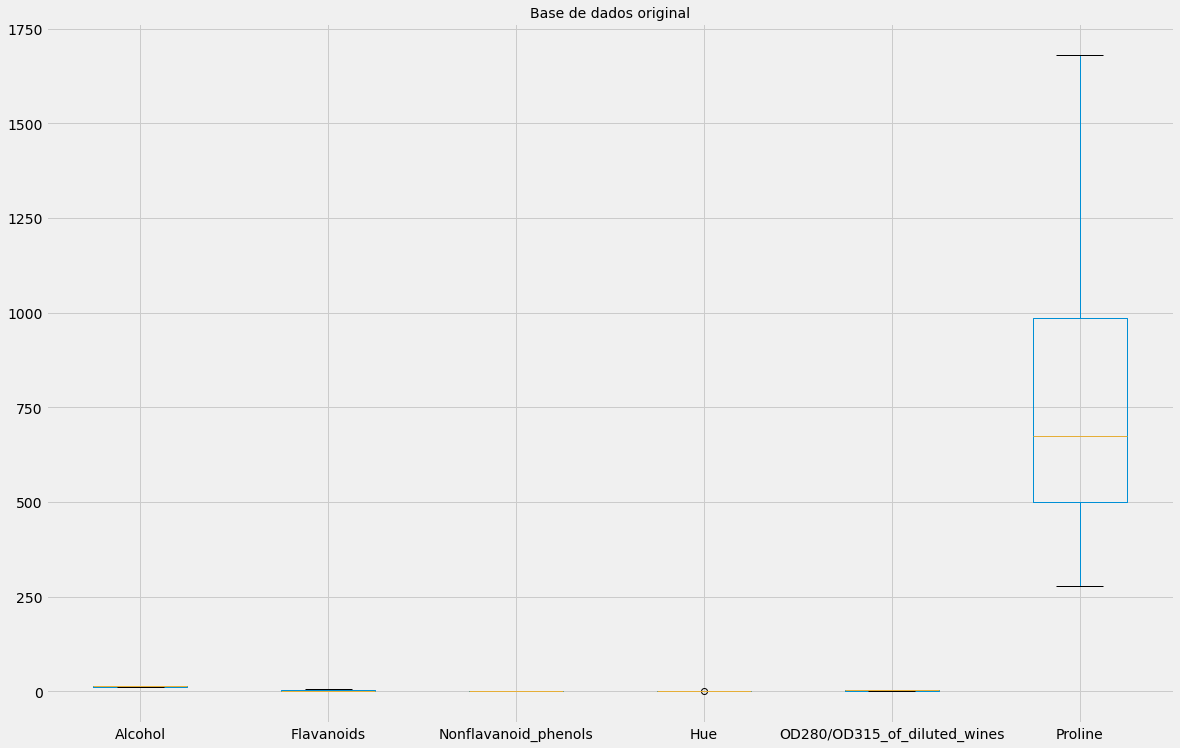

In [870]:
df.boxplot(grid=True, figsize= (18,12))
plt.title('Base de dados original', fontsize=14)

Text(0.5, 1.0, 'Base de dados sem o proline')

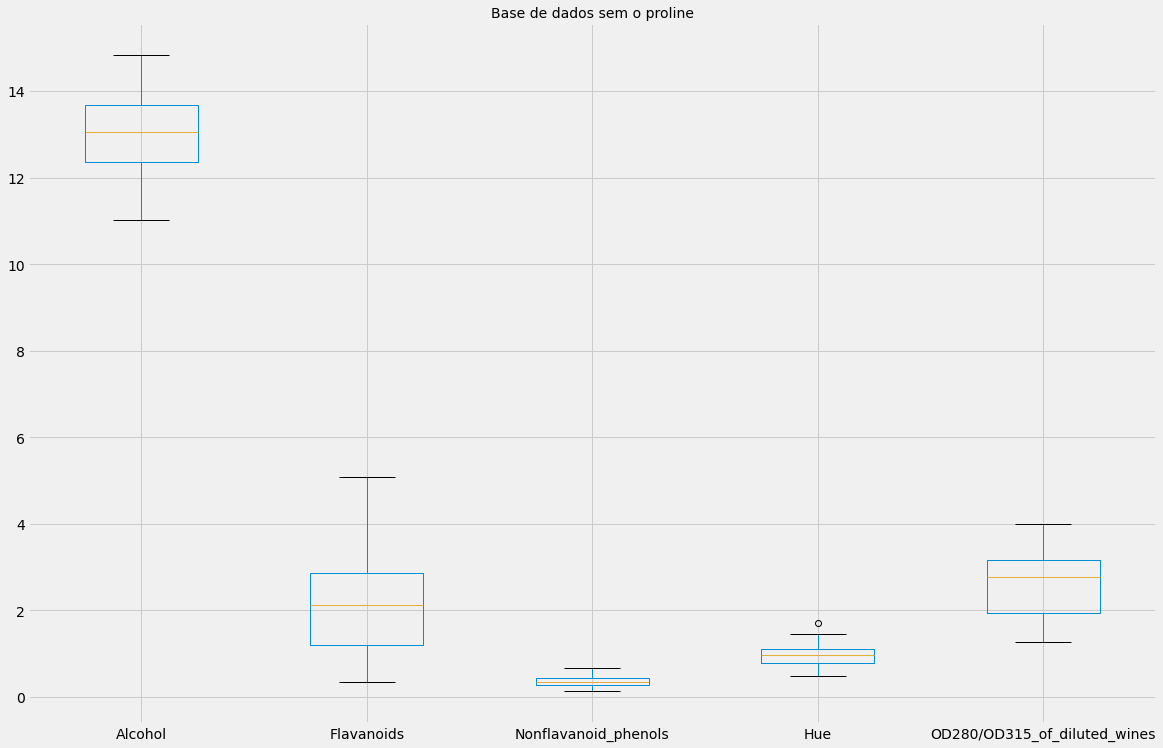

In [871]:
#plot sem o Proline
df.loc[:, df.columns != 'Proline'].boxplot(grid=True, figsize= (18,12))
plt.title('Base de dados sem o proline', fontsize=14)

In [872]:

columns = [
    (['Alcohol'], StandardScaler()),
    #(['Malic_acid'], StandardScaler()),
    #(['Ash'], StandardScaler()),
    #(['Alcalinity_of_ash'], StandardScaler()),
    #(['Magnesium'],StandardScaler()),
    (['Flavanoids'], StandardScaler()),
    (['Nonflavanoid_phenols'], None),
    #(['Proanthocyanins'], StandardScaler()),
    #(['Color_intensity'], StandardScaler()),
    (['Hue'], None),
    (['Proline'], StandardScaler()),
    #(['Total_phenols'], StandardScaler()),
    (['OD280/OD315_of_diluted_wines'], StandardScaler())
    
    
    
]
df_orig=df
mapper = DataFrameMapper(columns, df_out=True)
df = mapper.fit_transform(df)

Text(0.5, 1.0, 'Base de dados sem o proline')

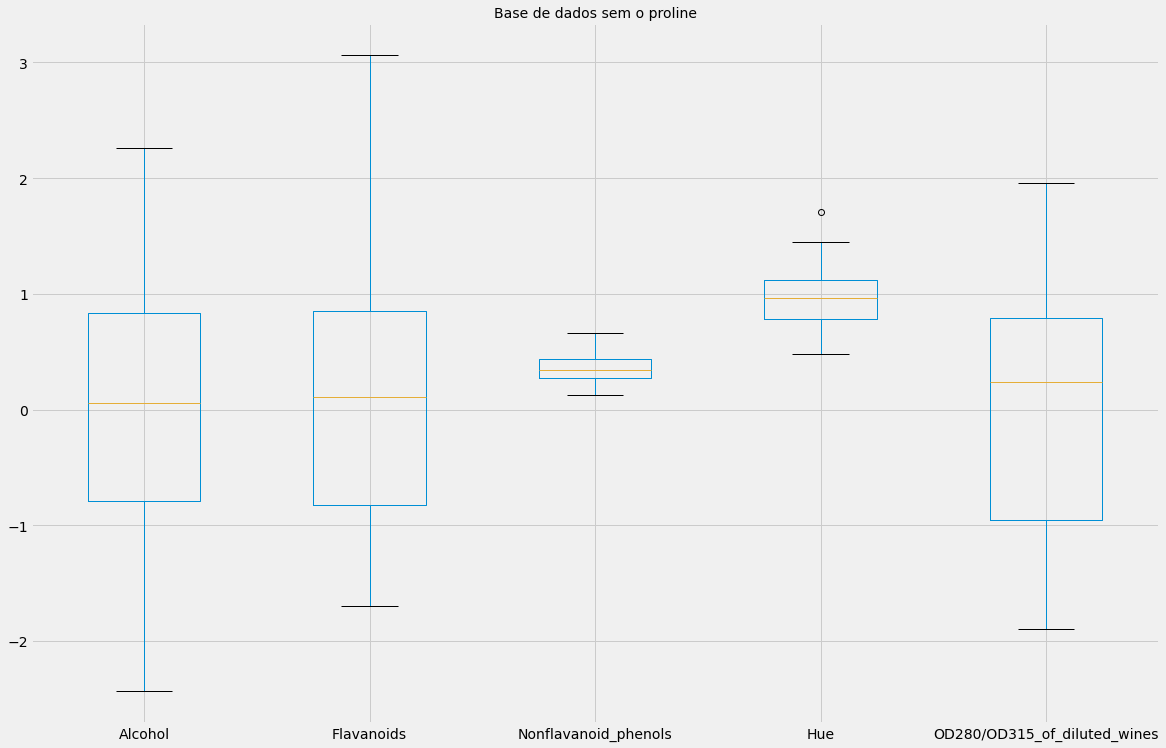

In [873]:
#plot sem o Proline
df.loc[:, df.columns != 'Proline'].boxplot(grid=True, figsize= (18,12))
plt.title('Base de dados sem o proline', fontsize=14)

In [874]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.style as style

range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_n_clusters = []

For n_clusters = 2 The average silhouette_score is : 0.43289567441527643
For n_clusters = 3 The average silhouette_score is : 0.4766419311556002
For n_clusters = 4 The average silhouette_score is : 0.3795002537241752
For n_clusters = 5 The average silhouette_score is : 0.316671601897418
For n_clusters = 6 The average silhouette_score is : 0.26358183207184277


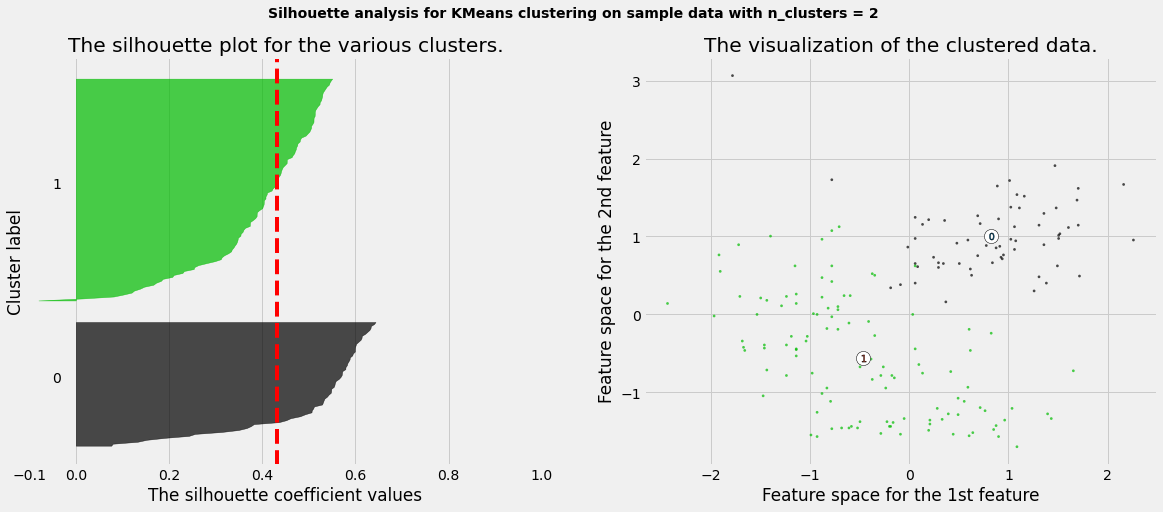

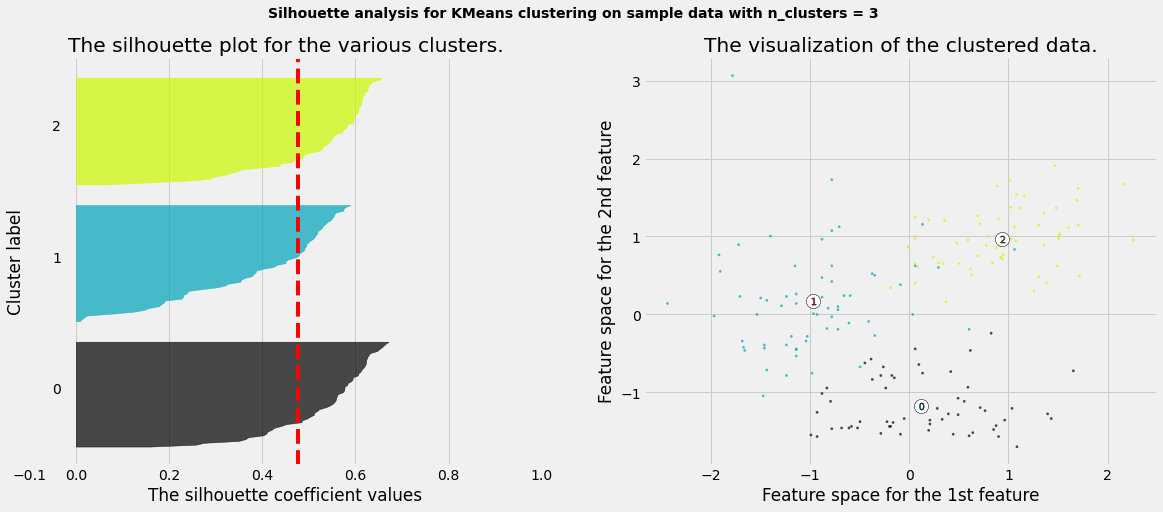

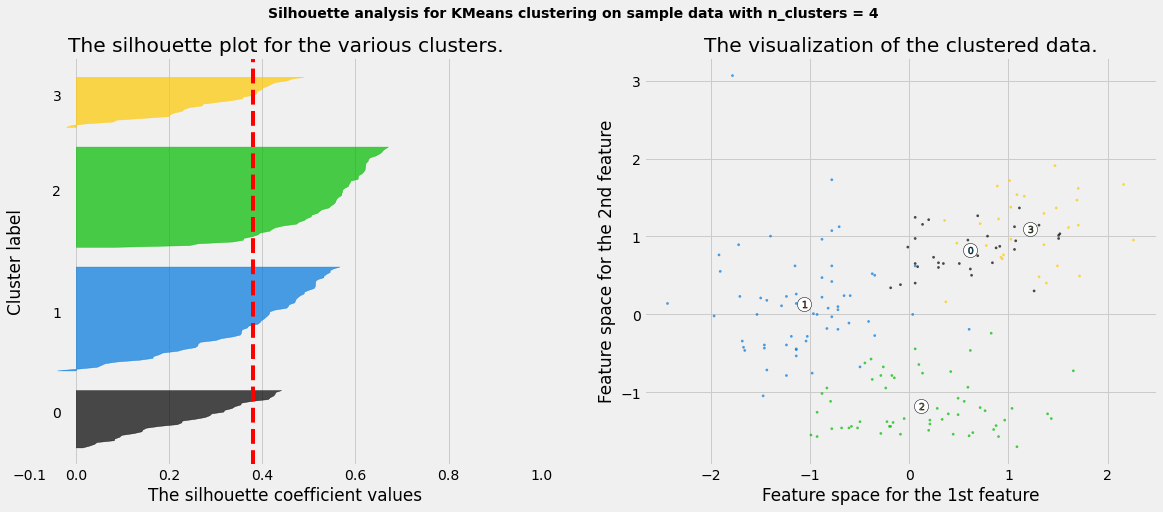

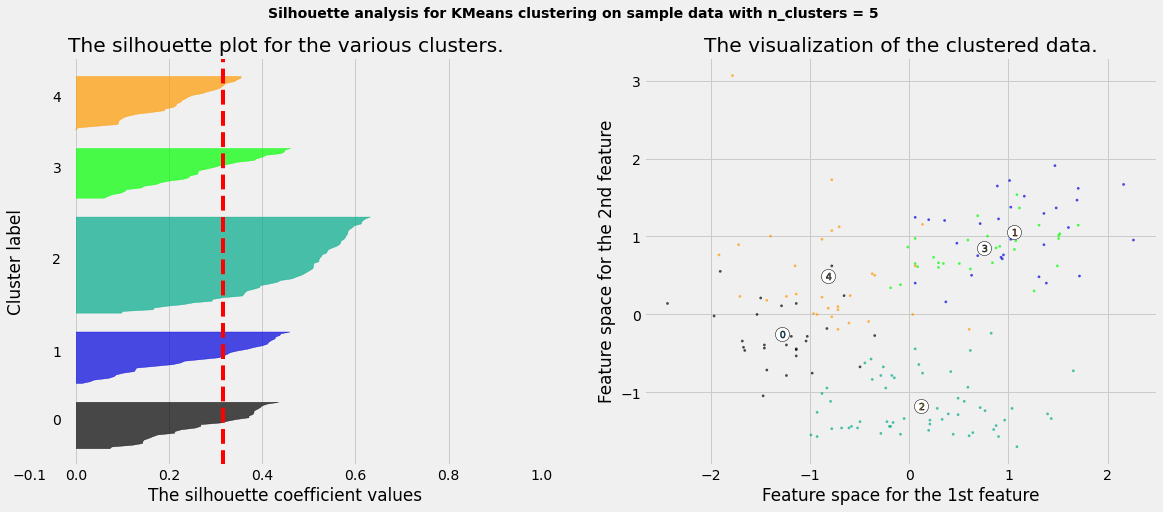

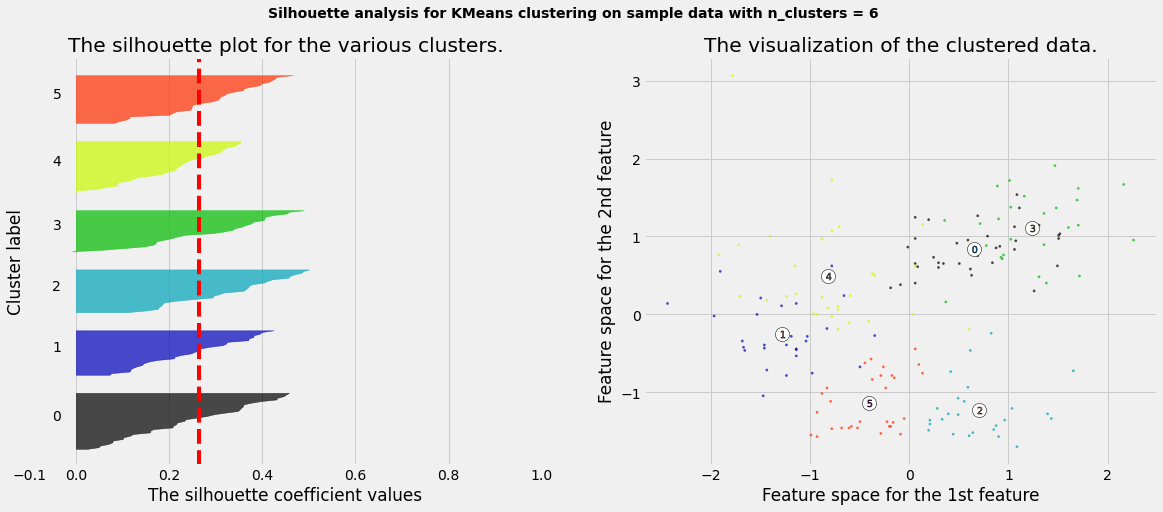

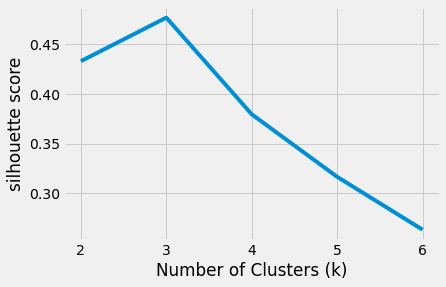

In [875]:
#Referência: https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=SEED)
    cluster_labels = clusterer.fit_predict(df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(df.iloc[:, 0], df.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


style.use("fivethirtyeight")
plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.6605093637856432
For n_clusters = 3 The average silhouette_score is : 0.5807840185597938
For n_clusters = 4 The average silhouette_score is : 0.5748547354943391
For n_clusters = 5 The average silhouette_score is : 0.5657651217290905
For n_clusters = 6 The average silhouette_score is : 0.5833821632026296


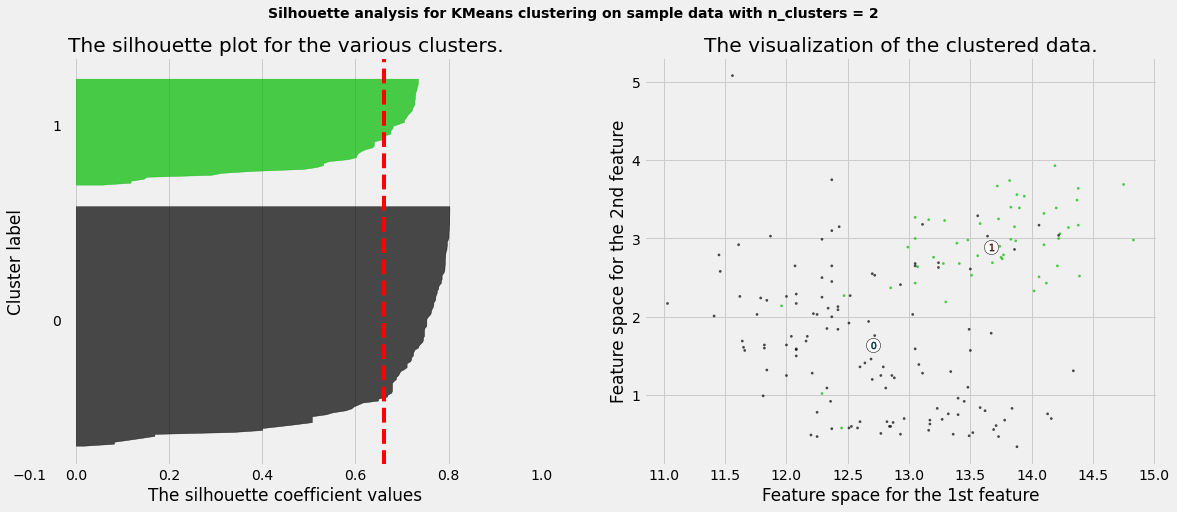

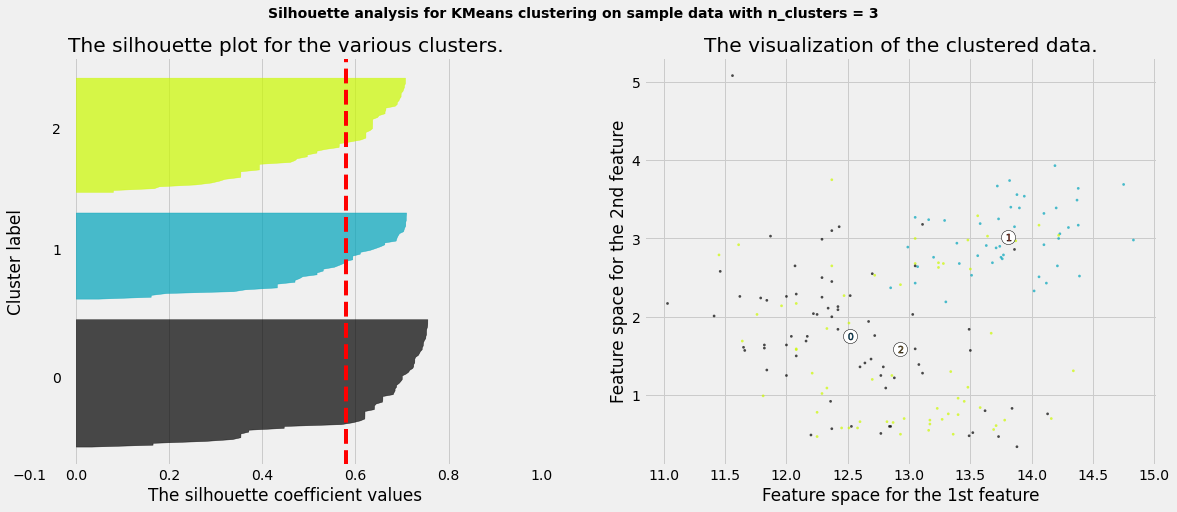

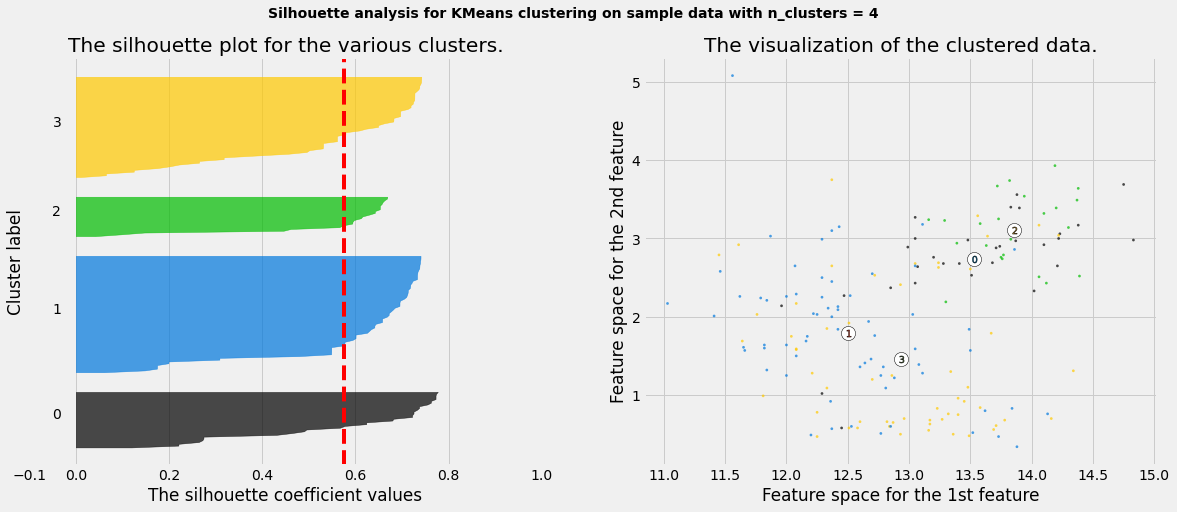

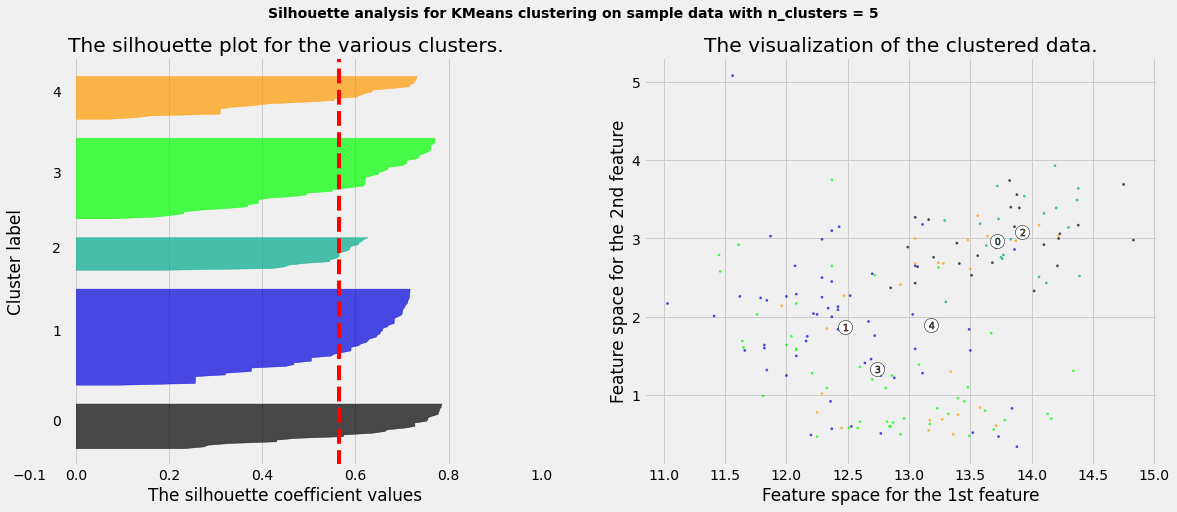

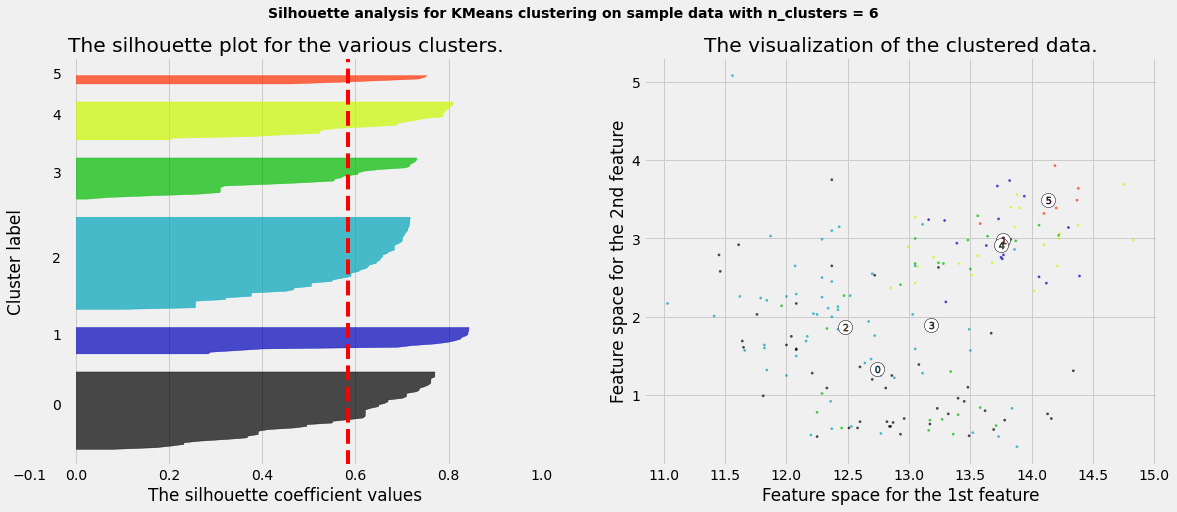

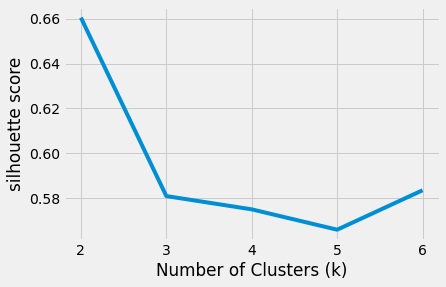

In [876]:
range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_n_clusters = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_orig) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=SEED)
    cluster_labels = clusterer.fit_predict(df_orig)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_orig, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_orig, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(df_orig.iloc[:, 0], df_orig.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


style.use("fivethirtyeight")
plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.show()